In [1]:
%matplotlib inline

In [2]:
from matplotlib import cm
from matplotlib import pyplot as plt
import numpy as np
from scipy import ndimage as ndi
from scipy import stats
from skimage import exposure, feature, filters, io, measure, morphology, restoration

In [3]:
def display(im3d, cmap="gray", figsize=(16, 14), step=2):
    _, axes = plt.subplots(nrows=5, ncols=6, figsize=figsize)
    
    vmin = im3d.min()
    vmax = im3d.max()
    
    for ax, image in zip(axes.flatten(), im3d[::step]):
        ax.imshow(image, cmap=cmap, vmin=vmin, vmax=vmax)
        ax.set_xticks([])
        ax.set_yticks([])
        
# Display label matrices with the background value set to black.
def get_cmap(labels, name="viridis"):
    cmap = cm.get_cmap("viridis")
    masked_labels = np.ma.masked_where(labels == 0, labels)
    cmap.set_bad(color="black")
    
    return masked_labels, cmap

# Improving the segmentation

In [4]:
data = io.imread("../../images/cells.tif")

original_spacing = (0.2900000, 0.0650000, 0.0650000)
rescaled_spacing = tuple(np.multiply((1.0, 4.0, 4.0), original_spacing))
spacing = tuple(np.divide(rescaled_spacing, rescaled_spacing[1]))

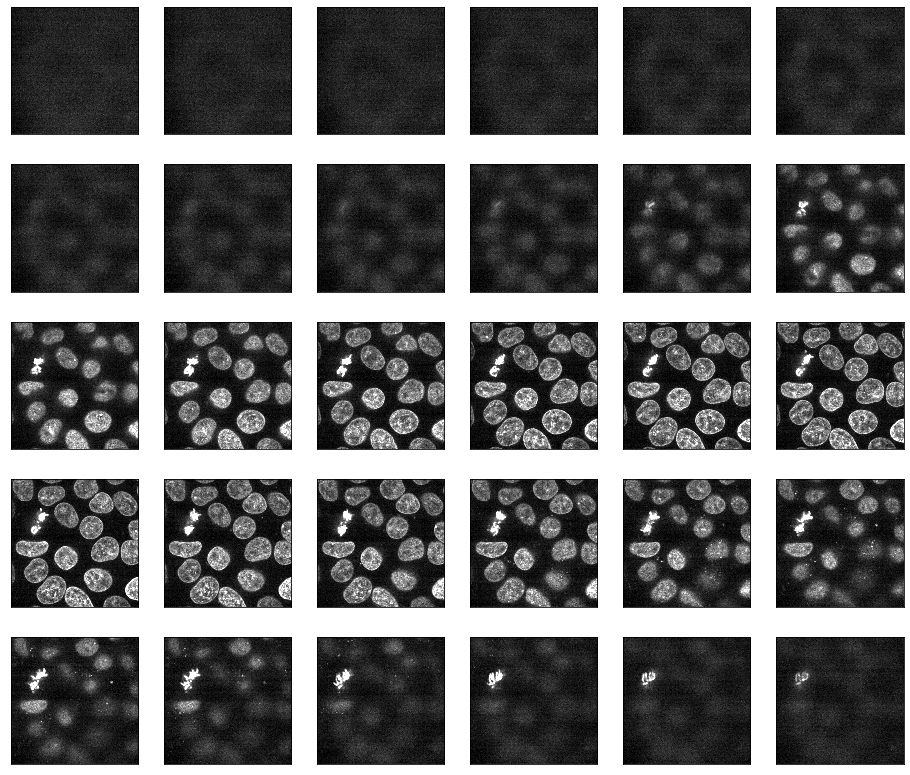

In [5]:
vmin, vmax = stats.scoreatpercentile(data, (0.5, 99.5))

rescaled = exposure.rescale_intensity(
    data,
    in_range=(vmin, vmax),
    out_range=np.double
)

display(rescaled)

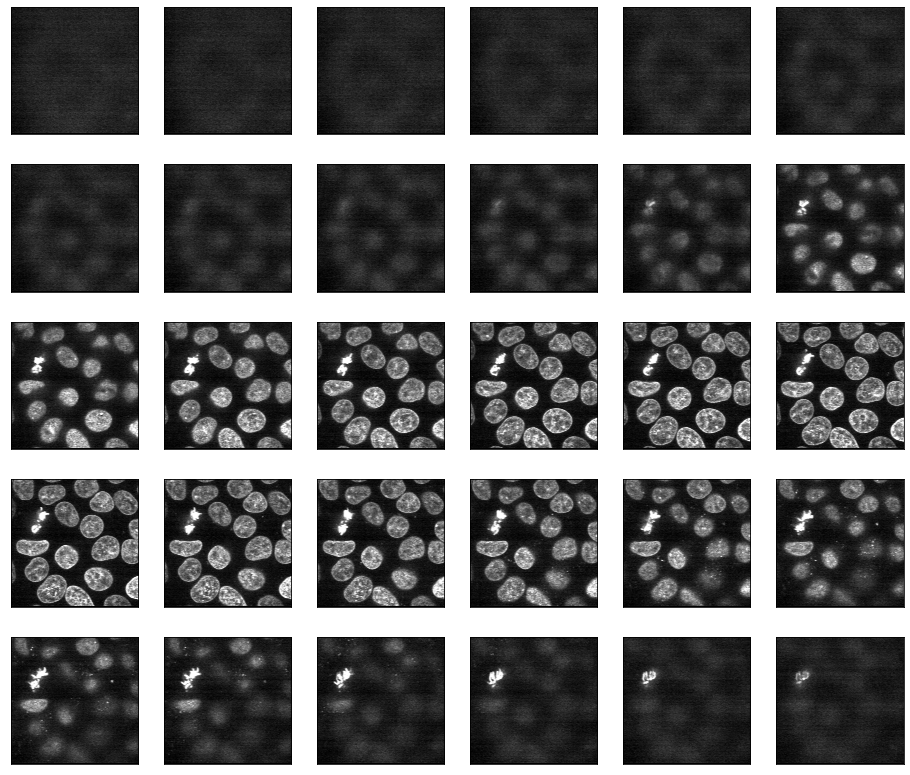

In [6]:
denoised = np.empty_like(rescaled)

for index, plane in enumerate(rescaled):
    denoised[index] = restoration.denoise_bilateral(
        plane, 
        multichannel=False
    )

display(denoised)

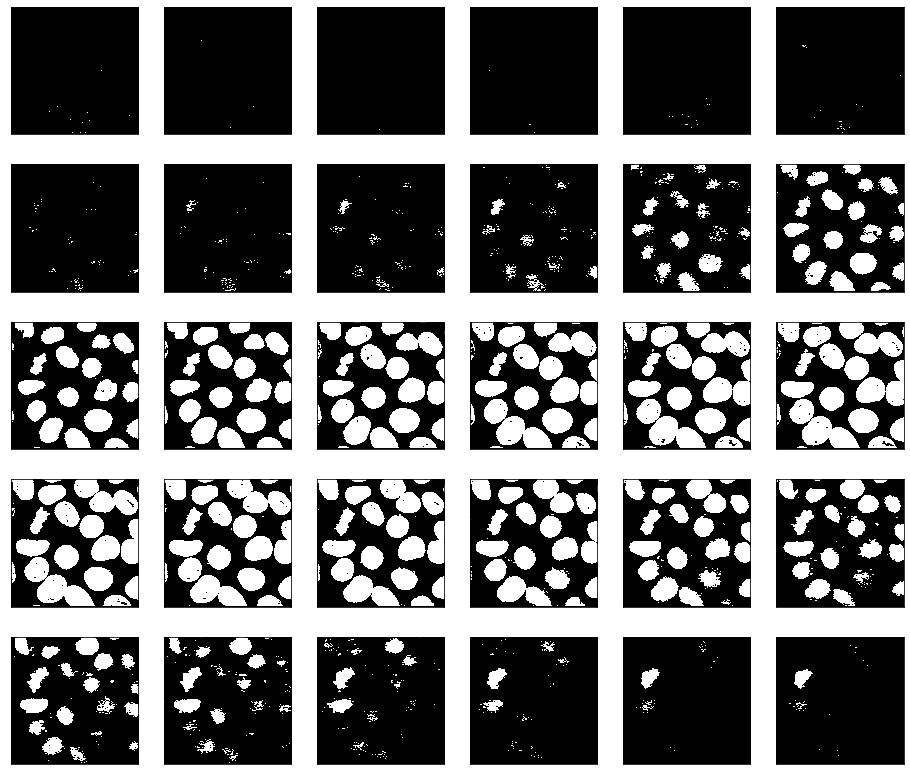

In [7]:
threshold = 0.9 * filters.threshold_li(denoised)

binary = denoised >= threshold

display(binary)

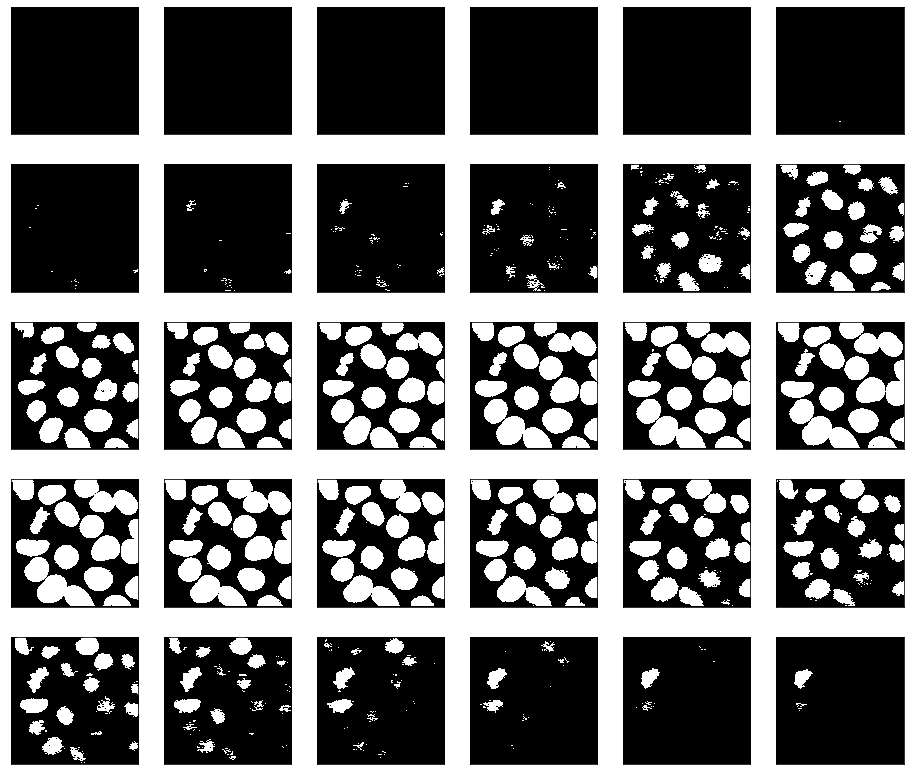

In [8]:
width = 20

remove_holes = morphology.remove_small_holes(
    binary, 
    area_threshold=np.product(np.divide(width, spacing))
)

remove_objects = morphology.remove_small_objects(
    remove_holes, 
    min_size=np.product(np.divide(width, spacing))
)

display(remove_objects)

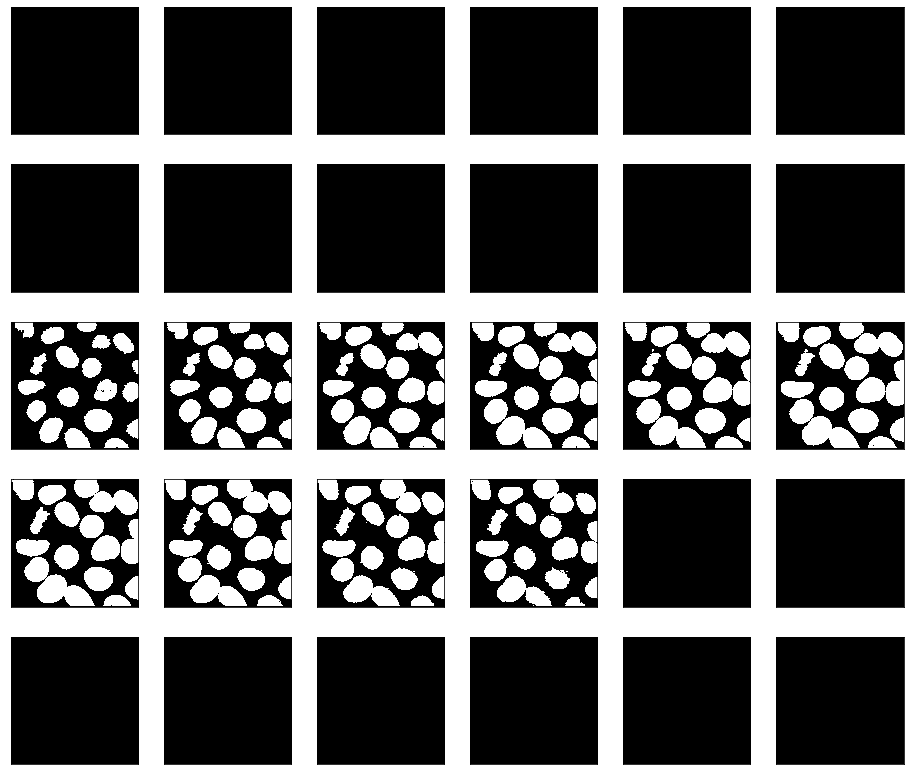

In [9]:
variance = [np.var(image) for _, image in enumerate(remove_objects)]

idx = np.argmax(variance)

seeded = np.zeros_like(remove_objects)

seeded[idx-10:idx+10] = remove_objects[idx-10:idx+10]

display(seeded)

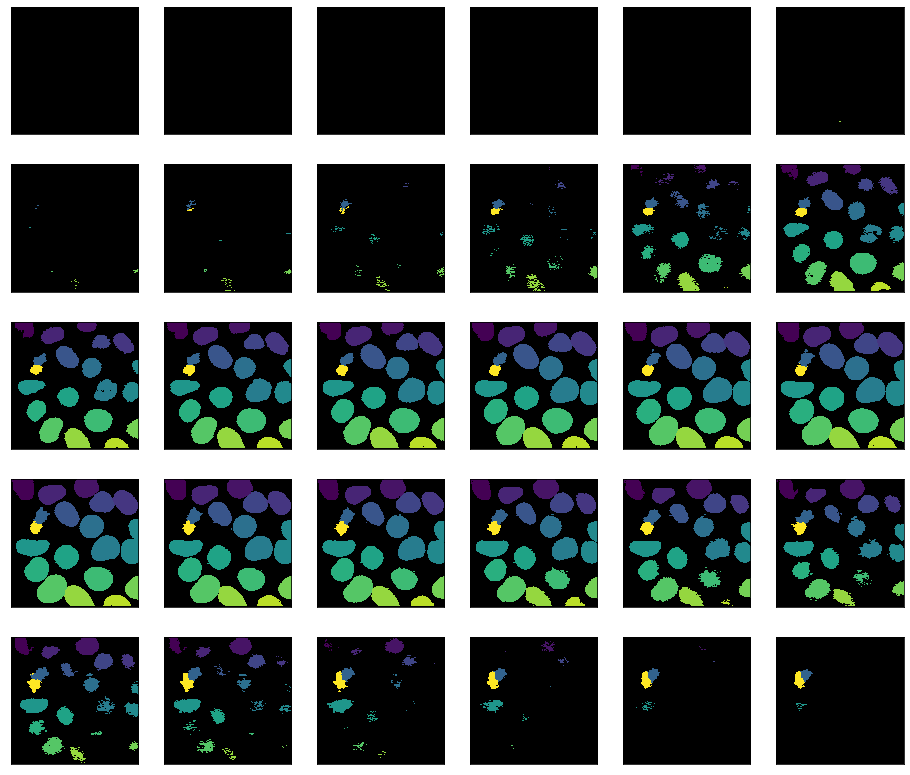

In [10]:
distance = ndi.distance_transform_edt(seeded)

peak_local_max = feature.peak_local_max(
    distance,
    footprint=np.ones((15, 15, 15), dtype=np.bool),
    indices=False,
    labels=measure.label(seeded)
)

markers = measure.label(peak_local_max)

labels = morphology.watershed(
    -rescaled, 
    markers, 
    mask=remove_objects
)

masked_labels, cmap = get_cmap(labels)

display(masked_labels, cmap=cmap)

# Membrane segmentation

In [11]:
data = io.imread("../../images/cells_membrane.tif")

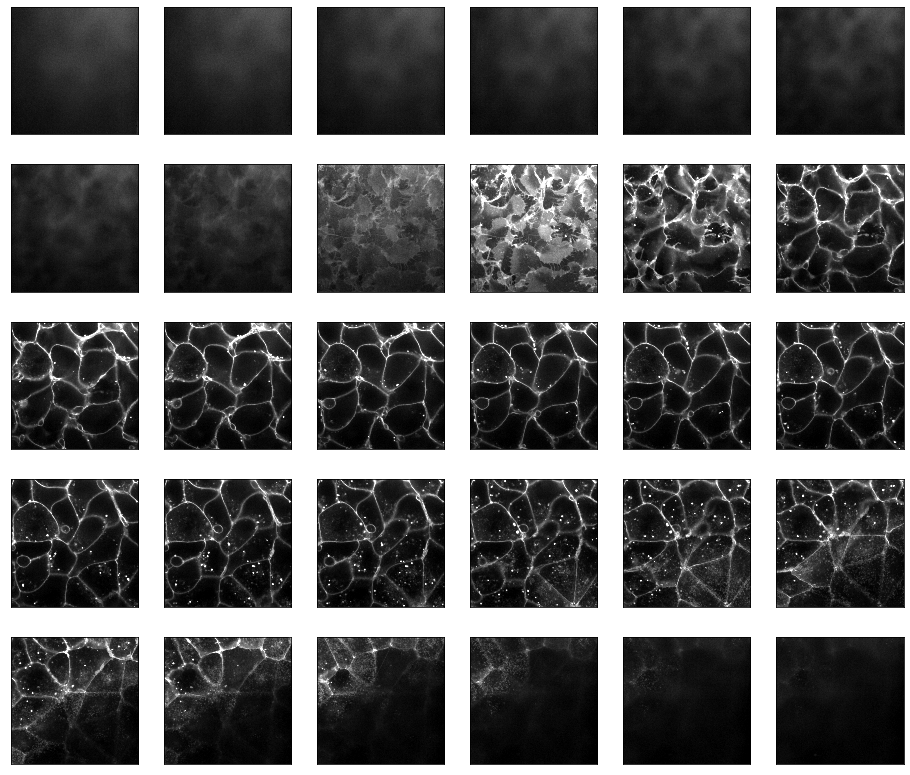

In [12]:
vmin, vmax = stats.scoreatpercentile(data, (0.5, 99.5))

rescaled = exposure.rescale_intensity(
    data,
    in_range=(vmin, vmax),
    out_range=np.float32
).astype(np.float32)

display(rescaled)

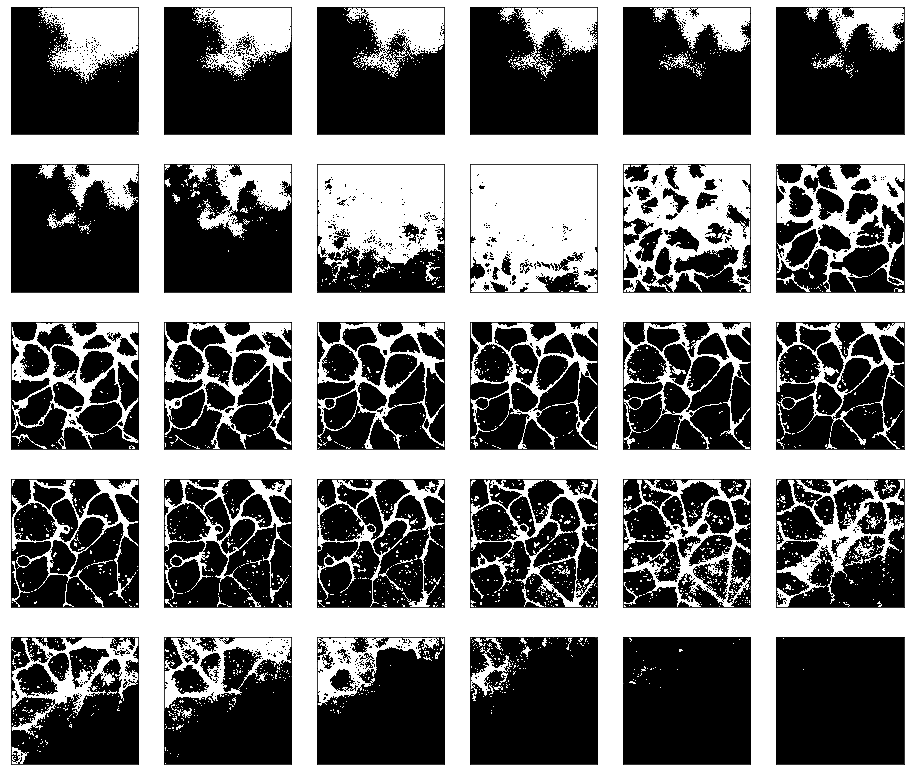

In [13]:
threshold = filters.threshold_li(rescaled)

binary = rescaled >= threshold

display(binary)

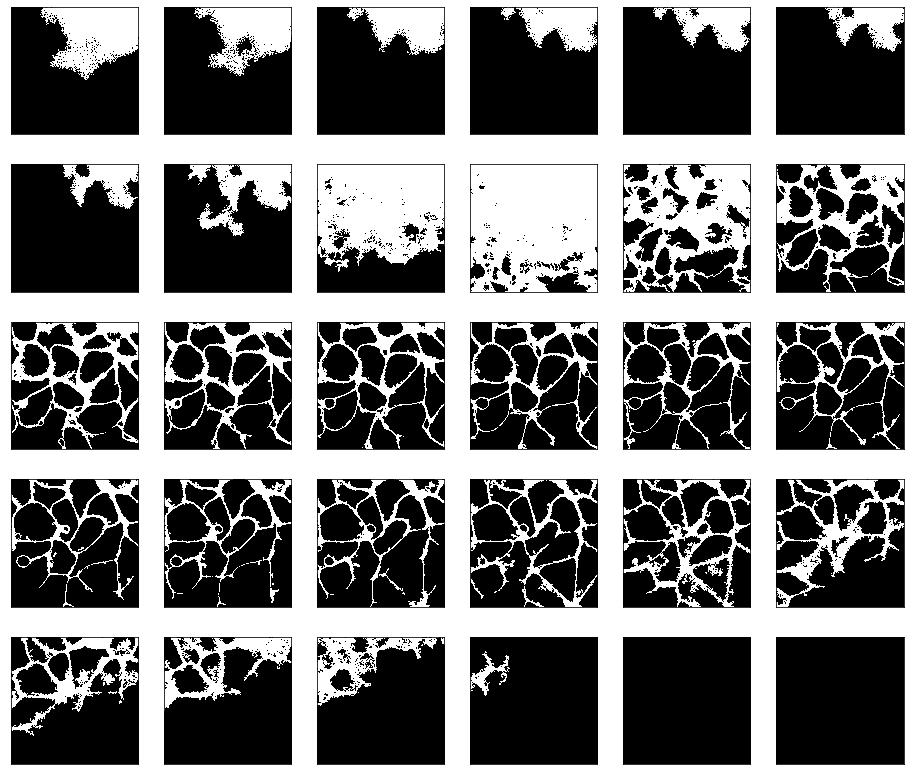

In [14]:
width = 40

remove_objects = np.empty_like(binary)

for plane, image in enumerate(binary):
    remove_objects[plane] = morphology.remove_small_objects(
        image, 
        min_size=width ** 2
    )
    
display(remove_objects)

In [15]:
bottom = (labels.max() + 1)
top = (labels.max() + 2)

markers = labels.copy()
markers[0] = bottom * np.ones_like(markers[0])
markers[-1] = top * np.ones_like(markers[-1])

membrane_labels = morphology.watershed(
    rescaled, 
    markers=markers, 
    mask=np.logical_not(remove_objects)
)

membrane_labels[membrane_labels == bottom] = 0
membrane_labels[membrane_labels == top] = 0

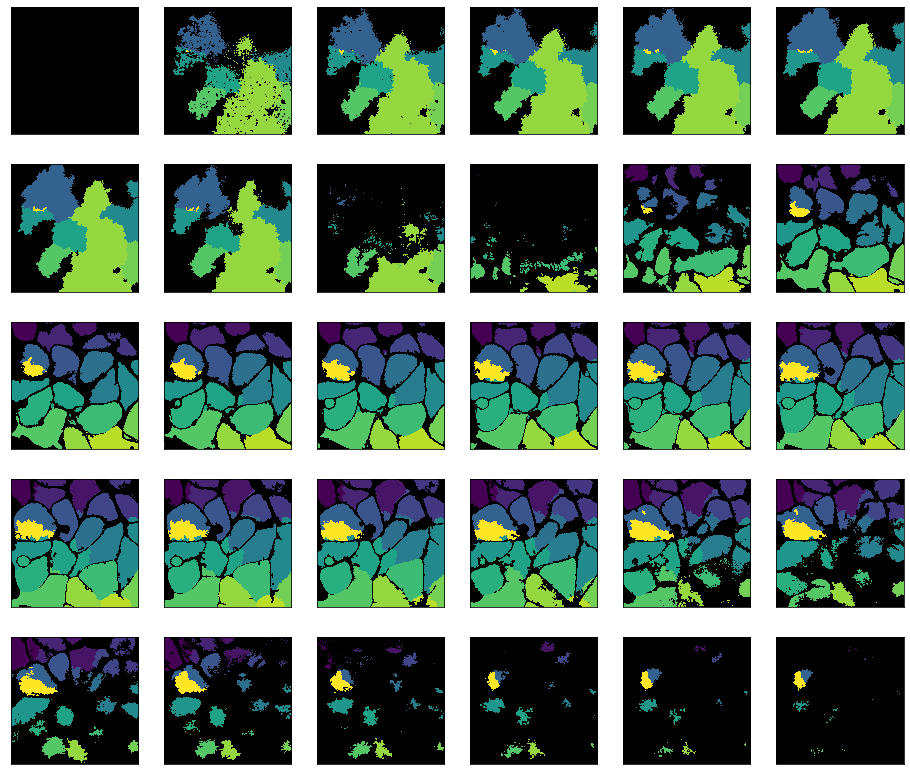

In [16]:
masked_labels, cmap = get_cmap(membrane_labels)

display(masked_labels, cmap=cmap)